In [12]:
from astroML.datasets import generate_mu_z
import matplotlib.pyplot as plt
import numpy as np

(35.0, 50.0)

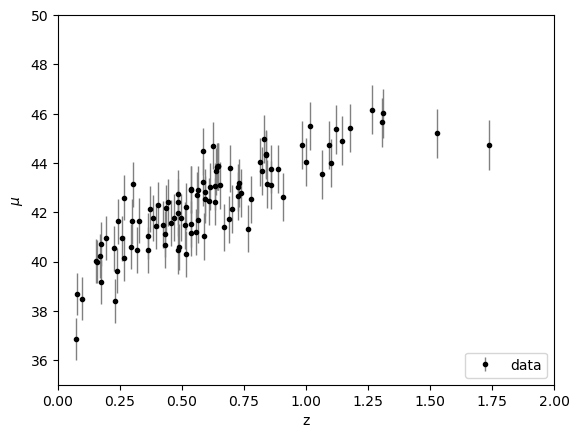

In [13]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

We want to first fit the data both with linear and polinomial regression.

In [14]:
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression

## Linear regression

In [21]:
linear_model = LinearRegression()
linear_model.fit(z_sample[:, None], mu_sample, dmu)

print(linear_model.coef_)

[39.48384602  4.76438865]


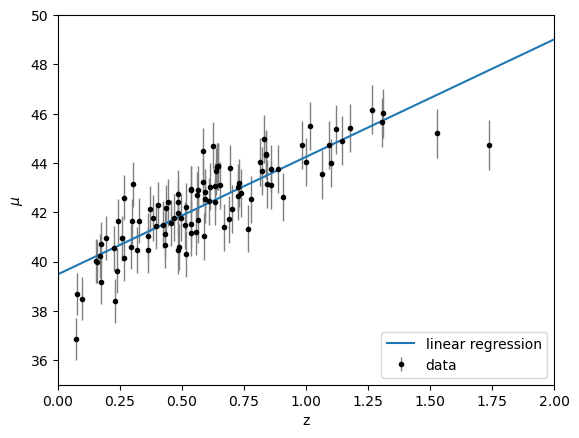

In [25]:
x = np.linspace(0, 2, 100)
f = linear_model.coef_[0] + linear_model.coef_[1] * x
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x, f, label = 'linear regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Polynomial regression

In [234]:
poly_model = []
for i in range(1, 20, 3):
    poly_model.append(PolynomialRegression(degree = i))

for i in range(len(poly_model)):
    poly_model[i].fit(z_sample[:, None], mu_sample, dmu)

print(poly_model[1].coef_)

[ 36.95622821  21.50098389 -34.55444621  28.77101798  -8.39275909]


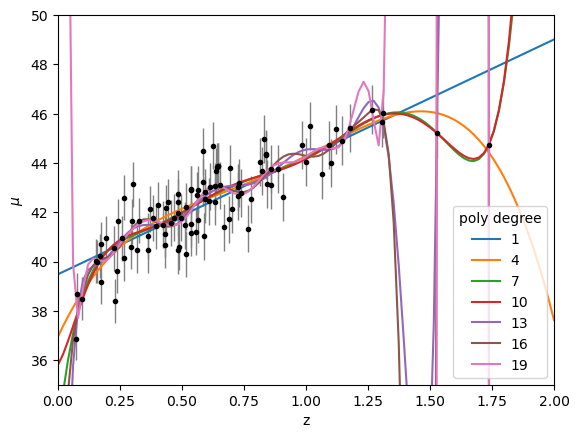

In [235]:
x = np.linspace(0, 2, 100)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
for i in range(len(poly_model)):
    f = np.zeros(100)
    for j in range(len(poly_model[i].coef_)):
        f += poly_model[i].coef_[j] * np.power(x, j)
    plt.plot(x, f, label = str(len(poly_model[i].coef_) - 1))

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(title = 'poly degree', loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

Higher degrees seem to overfit the data, while a Linear Regression underfits it. Let's draw only the lines which seem to fit the data best.

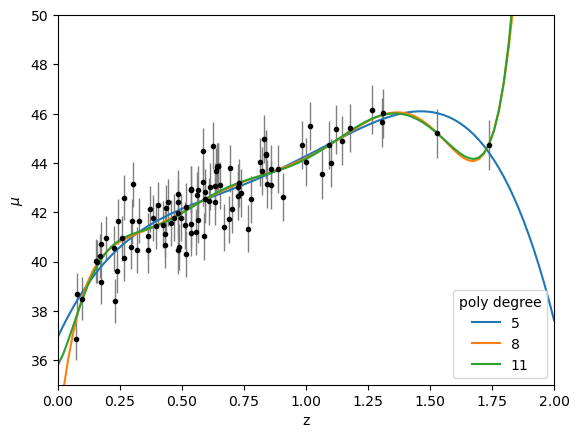

In [236]:
x = np.linspace(0, 2, 100)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
for i in range(1, 4):
    f = np.zeros(100)
    for j in range(len(poly_model[i].coef_)):
        f += poly_model[i].coef_[j] * np.power(x, j)
    plt.plot(x, f, label = str(len(poly_model[i].coef_)))

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(title = 'poly degree', loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

The 5 degree line seems to be the best up to now, as the data doesn't show signs of raising once it gets close to 2, like the 8 and 11 degree lines suggest instead.

## Basis function regression

In [237]:
from astroML.linear_model import BasisFunctionRegression

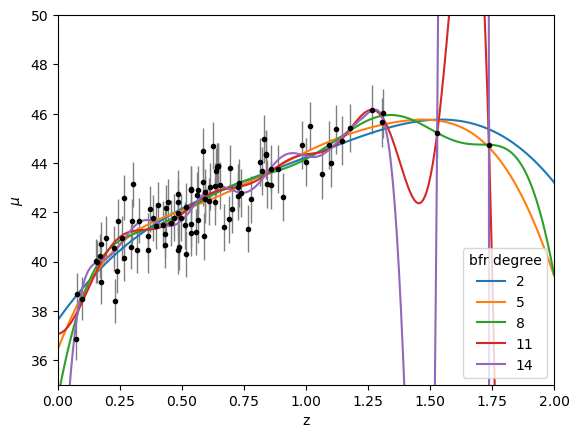

In [238]:
#print(np.mean(z_sample))
x = np.linspace(0, 2, 500)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

for n in range(2, 15, 3):
    basis_mu = np.linspace(0, 2, n)
    basis_sigma = 2 / n
    bfr = BasisFunctionRegression('gaussian', mu = basis_mu[:, None], sigma = basis_sigma)
    bfr.fit(z_sample[:, None], mu_sample, dmu)
    f = bfr.predict(x[:, None])
    plt.plot(x, f, label = str(n))
    
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(title = 'bfr degree', loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Kernel Regression

In [239]:
from astroML.linear_model import NadarayaWatson

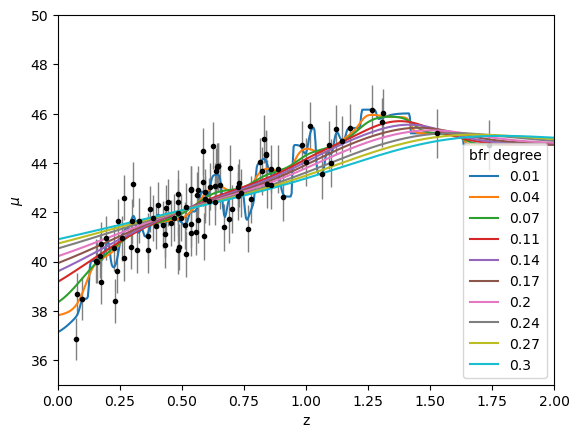

In [240]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

h_range = np.round(np.linspace(0.01, 0.3, 10), 2)
for bw in h_range:
    kr = NadarayaWatson(kernel='gaussian', h = bw)
    kr.fit(z_sample[:, None], mu_sample)
    f = kr.predict(x[:, None])
    plt.plot(x, f, label = str(bw))

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(title = 'bfr degree', loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Cross-validation
To pick the actual best line, we want to split our data into training and validation and analyse our error function.

In [241]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

In [242]:
X = np.copy(z_sample[:, None])
y = np.copy(mu_sample)
dy = np.copy(dmu)

X_train, X_val, ydy_train, ydy_val = train_test_split(X, np.array([y,dy]).T, test_size=0.3, random_state = 4)
y_train,dy_train = ydy_train.T
y_val,dy_val = ydy_val.T

<ErrorbarContainer object of 3 artists>

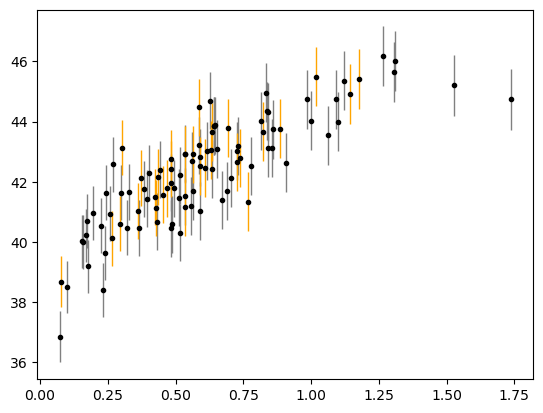

In [243]:
plt.errorbar(X_train[:], y_train, dy_train, fmt='.k', ecolor='gray', lw=1)
plt.errorbar(X_val[:], y_val, dy_val, fmt='.k', ecolor='orange', lw=1)

In [244]:
def error_func(X, y, model):
    return np.sqrt( (1/len(X)) * (np.sum((y - model.predict(X)) ** 2)) )
    
def get_err (model):
    model.fit(X_train, y_train)
    error_train = error_func(X_train, y_train, model)
    error_val = error_func(X_val, y_val, model)
    return error_train, error_val

### Linear regression error

In [245]:
model = LinearRegression()
err_train, err_val = get_err (model)
print('error on training set: ', err_train, '; error on validation set: ', err_val)

error on training set:  1.0179894221442145 ; error on validation set:  0.9289881809860042


### Polynomial regression error

2 0.9235108471721167 0.8668488900051456
3 0.9220913273962321 0.8740635551539032
4 0.892243878385677 0.8313689965530031
5 0.8799620191583813 0.8425108576485594
6 0.8685925119328037 0.8788059020754334
7 0.8373328247312626 0.9303484111853237
8 0.8355633892561264 0.9344351151671149
9 0.8347329874514332 0.9334083145601639
10 0.8305242643046634 0.9590722905582924
11 0.8284178183526045 0.9574274644772399
12 0.8180311242701199 0.9335190835228472
13 0.8179349176589311 0.9315424056129981
14 0.7989275648144244 0.9598936677686541
15 0.7989184834426748 0.962330116249245
16 0.7985249239540713 0.940642217519479
17 0.7974782137048286 0.964788484431895
18 0.7844953273532302 0.9995006846499821
19 0.7878713532150994 0.9685688940308066


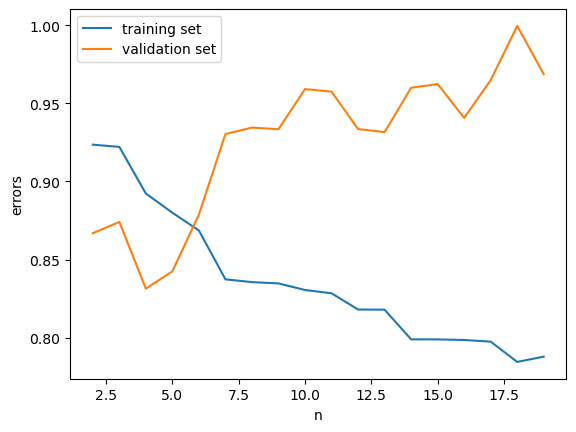

In [246]:
err_train = []
err_val = []

for n in range(2, 20):
    model = PolynomialRegression(degree = n)
    a, b = get_err(model)
    print(n, a, b)
    err_train.append(a)
    err_val.append(b)

plt.plot(range(2, 20), err_train, label = 'training set')
plt.plot(range(2, 20), err_val, label = 'validation set')
plt.xlabel('n')
plt.ylabel('errors')
plt.legend()
plt.show()

If the validation set takes one of the two 'outliers' into account, the errors skyrocket at high degree. The validation error being lower than the training set could inply that the validation set could have been chosen [to be unrepresentative of the total space (e.g., restricted to easy examples)](https://www.researchgate.net/post/When_training_a_deep_learning_model_should_the_validation_loss_be_greater_than_or_smaller_than_the_training_loss), pick i.e. random_state = 3.

In [247]:
print('The best line is the ', np.argmin(err_val) + 2, 'th degree one.')

The best line is the  4 th degree one.


### Basis Function Regression error

2 0.9085504275813739 0.8400946121654697
3 0.908371771088053 0.8425731855396451
4 0.8932879661884586 0.8299492378829973
5 0.8830879676759968 0.8477753265576583
6 0.8687835847857244 0.8883410288188053
7 0.8351345736407653 0.932430068993882
8 0.8342791162937746 0.9348797005645877
9 0.8339091379221593 0.9381822350694362
10 0.8334042732825473 0.9413503974050448
11 0.8309711642158948 0.9275784811254342
12 0.8317384068231383 0.9330319066722395
13 0.8096522453466437 1.0103328488549002
14 0.7983140730637864 0.942099419828883


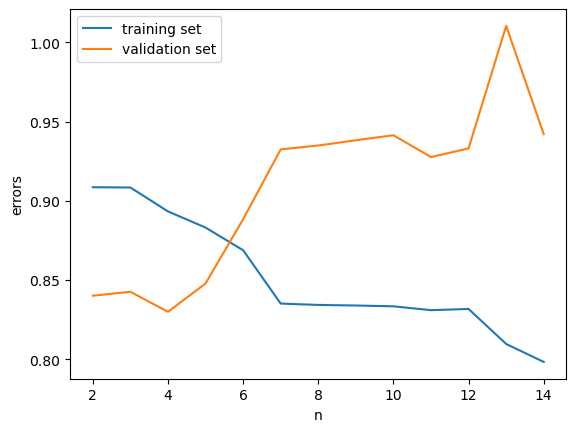

In [248]:
err_train = []
err_val = []


for n in range(2, 15):
    basis_mu = np.linspace(0, 2, n)
    basis_sigma = 2 / n
    model = BasisFunctionRegression('gaussian', mu = basis_mu[:, None], sigma = basis_sigma)
    a, b = get_err(model)
    print(n, a, b)
    err_train.append(a)
    err_val.append(b)

plt.plot(range(2, 15), err_train, label = 'training set')
plt.plot(range(2, 15), err_val, label = 'validation set')
plt.xlabel('n')
plt.ylabel('errors')
plt.legend()
plt.show()

### Kernel regression error

0.01 0.5640326636142895 1.053685446951565
0.04 0.7713190880906483 0.8626402389872209
0.07 0.8665481968877065 0.8667516358648429
0.11 0.9275995036476717 0.889032010475797
0.14 0.9587571072074712 0.9014579826456733
0.17 0.9923469215532438 0.9206575740071874
0.2 1.032391831598205 0.9480662236283763
0.24 1.0943596327165437 0.9928702060208356
0.27 1.1440195016397874 1.028908168772271
0.3 1.193884796195041 1.0647765702660217


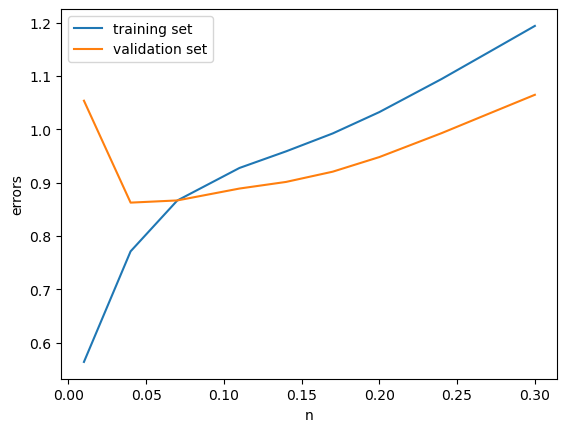

In [249]:
err_train = []
err_val = []

for bw in h_range:
    model = NadarayaWatson(kernel='gaussian', h = bw)
    a, b = get_err(model)
    print(bw, a, b)
    err_train.append(a)
    err_val.append(b)

plt.plot(h_range, err_train, label = 'training set')
plt.plot(h_range, err_val, label = 'validation set')
plt.xlabel('n')
plt.ylabel('errors')
plt.legend()
plt.show()

## Changing the number of datapoints

I've seen that the last two datapoints (z $\geq$ 1.5) skew the results significantly if they get separated, meaning if one of them ends up in the training set and the other doesn't. Let's try to exclude them entirely and use the best fit model we have found: the 4th degree polynomial model (The best overall is the 4th degree basis function model, but the polynomial is overall easier to use).

In [250]:
off_data_index = []
for i in range(len(z_sample)):
    if (z_sample[i] > 1.4):
        off_data_index.append(i)

new_z = np.delete(z_sample, off_data_index)
new_mu = np.delete(mu_sample, off_data_index)
new_dmu = np.delete(dmu, off_data_index)

[ 36.95622821  21.50098389 -34.55444621  28.77101798  -8.39275909]


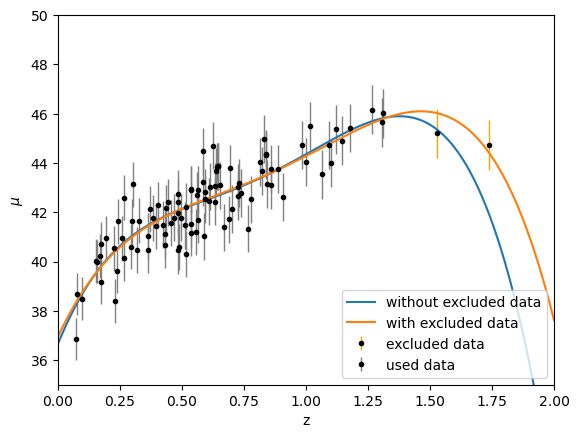

In [266]:
poly_model4 = PolynomialRegression(degree = 4)

poly_model4.fit(new_z[:, None], new_mu, new_dmu)

print(poly_model[1].coef_)

x = np.linspace(0, 2, 500)

plt.errorbar(z_sample[off_data_index], mu_sample[off_data_index], dmu[off_data_index], fmt='.k', ecolor='orange', lw=1, label = 'excluded data')
plt.errorbar(new_z, new_mu, new_dmu, fmt='.k', ecolor='gray', lw=1, label = 'used data')

f = np.zeros(len(x))
f1 = np.zeros(len(x))

for i in range(len(poly_model4.coef_)):
    f += poly_model4.coef_[i] * np.power(x, i)
    f1 += poly_model[1].coef_[i] * np.power(x, i)
    
plt.plot(x, f, label = 'without excluded data')
plt.plot(x, f1, label = 'with excluded data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

Seems like at lower degrees it doesn't change much.